<a href="https://colab.research.google.com/github/MCanhisares/DLStudies/blob/master/PyTorchForDLS8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torchvision import datasets, transforms

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
transform = transforms.Compose([transforms.Resize((28,28)),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1,2,0)
  image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  return image


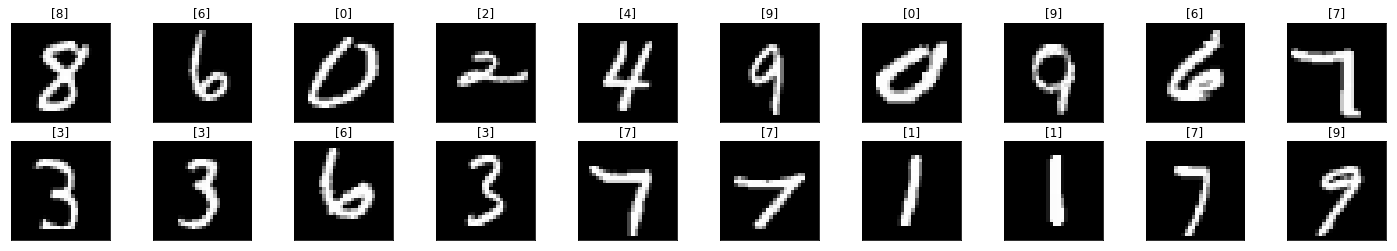

In [5]:
dataiter = iter(training_loader)
images,labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2,10,idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,20,5,1)
    self.conv2 = nn.Conv2d(20,50,5,1)
    self.fc1 = nn.Linear(4*4*50, 500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10)
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1 , 4*4*50)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

In [22]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [24]:
epochs = 12
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)    
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
      
        _, val_preds = torch.max(val_outputs, 1)    
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
    
      
    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float()/len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)    
    
    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    
    print(f'epoch {e + 1}')
    print('training loss: {:.4f}, {:.4f}'.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

epoch 1
training loss: 0.0059, 0.8381
validation loss: 0.0020, 0.9384
epoch 2
training loss: 0.0016, 0.9529
validation loss: 0.0011, 0.9646
epoch 3
training loss: 0.0011, 0.9682
validation loss: 0.0008, 0.9758
epoch 4
training loss: 0.0008, 0.9746
validation loss: 0.0007, 0.9786
epoch 5
training loss: 0.0007, 0.9792
validation loss: 0.0006, 0.9820
epoch 6
training loss: 0.0006, 0.9817
validation loss: 0.0005, 0.9831
epoch 7
training loss: 0.0005, 0.9833
validation loss: 0.0005, 0.9851
epoch 8
training loss: 0.0005, 0.9854
validation loss: 0.0004, 0.9871
epoch 9
training loss: 0.0004, 0.9868
validation loss: 0.0004, 0.9865
epoch 10
training loss: 0.0004, 0.9880
validation loss: 0.0004, 0.9872
epoch 11
training loss: 0.0004, 0.9888
validation loss: 0.0003, 0.9893
epoch 12
training loss: 0.0003, 0.9904
validation loss: 0.0003, 0.9888


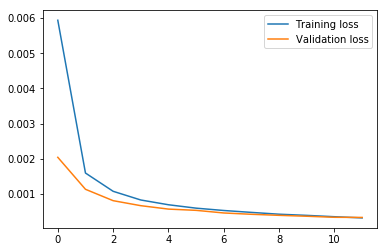

In [25]:
plt.plot(running_loss_history, label='Training loss')
plt.plot(val_running_loss_history, label='Validation loss')
plt.legend()

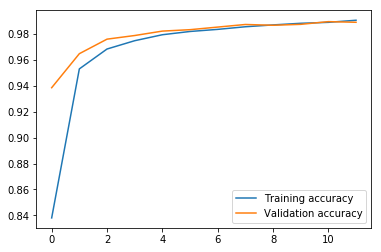

In [26]:
plt.plot(running_corrects_history, label='Training accuracy')
plt.plot(val_running_corrects_history, label='Validation accuracy')
plt.legend()

In [0]:
import PIL.ImageOps

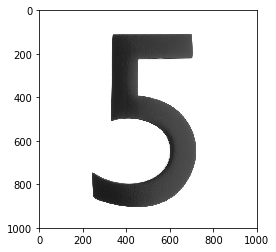

In [28]:
import requests
from PIL import Image
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)


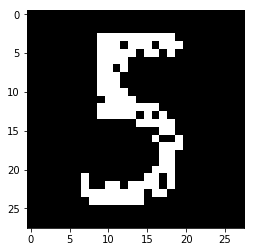

In [29]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img))

In [37]:
images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0)
output = model(image)     
_, pred = torch.max(output, 1) 
print(pred.item())

5


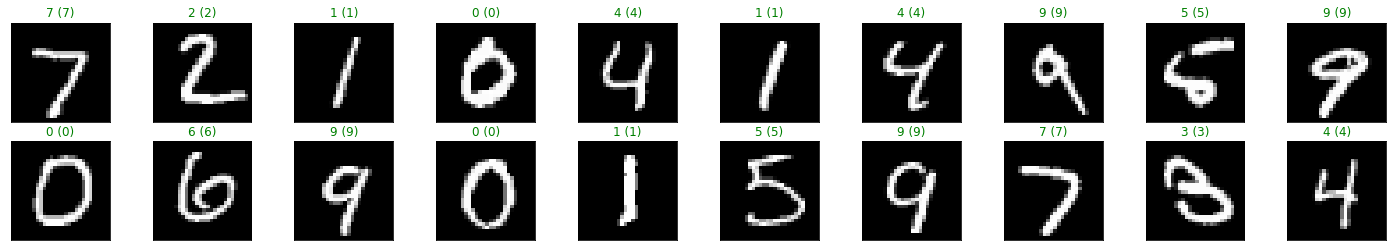

In [39]:
dataiter = iter(validation_loader)
images,labels = dataiter.next()
labels = labels.to(device)
images = images.to(device)
output = model(images)    
_, preds = torch.max(output, 1) 

fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2,10,idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red") )